**Subjectivity Mining: Assignment 3**

**Group 4**

Wafaa Aljbawi		

Andreea Hazu, 2645225; 	

Hein Kolk	 

Jelle Wassenaar

**Important links**
* [Report](https://www.overleaf.com/1866814561gxsxhbgqwjzv)
* [Github Repo](https://github.com/andreeahazu/SM_A3)

**Data**

In this assignment, you will be working with the [OLIDv1 dataset](https://github.com/idontflow/OLID), which contains 13,240 annotated messages (tweets) for offensive language detection. The detailed description of the dataset collection and annotation procedures can be found [here](https://aclanthology.org/N19-1144.pdf). This dataset was used in the SemEval 2019 shared task on offensive language detection ([OffensEval 2019](https://aclanthology.org/S19-2010.pdf)).

The focus is on Subtask A (identify whether a tweet is offensive or not). We preprocessed the dataset so that label ‘1’ corresponds to offensive messages (‘OFF’ in the dataset description paper) and ‘0’ to non-offensive messages (‘NOT’ in the dataset description paper) and selected a subset of the OLIDv1 train dataset of the same size and with the same label distribution as the
HASOC train dataset (below): olid-train-small.csv. The test set is the same as used in the shared task: olid-test.csv.

The second dataset you will be using in this assignment is the [HASOC dataset](https://dl-acm-org.vu-nl.idm.oclc.org/doi/pdf/10.1145/3368567.3368584) (only the training set of the English dataset composed of tweets and Facebook messages). The dataset was preprocessed in the same way as the OLIDv1 dataset: label ‘1’ corresponds to hateful/offensive messages and ‘0’ to non-hateful/non-offensive messages.

The training (small) and test partitions of the OLIDv1 dataset (olid-train-small.csv and olid-test.csv, respectively) and the HASOC train dataset (hasoc-train.csv) can be found [here](https://canvas.vu.nl/courses/63973/files/5284148?wrap=1).

3 datasets:
*   OLID-train-small
*   OLID-test
*   HASOC-train

## Imports

#### Install Dependencies and Restart Runtime for BERT Model

In [ ]:
# Install simpletransformers library
!pip install -q transformers
!pip install -q simpletransformers

     |████████████████████████████████| 5.3 MB 5.1 MB/s 
     |████████████████████████████████| 163 kB 68.4 MB/s 
     |████████████████████████████████| 7.6 MB 40.6 MB/s 
     |████████████████████████████████| 250 kB 4.8 MB/s 
     |████████████████████████████████| 1.3 MB 40.4 MB/s 
     |████████████████████████████████| 441 kB 48.1 MB/s 
     |████████████████████████████████| 1.9 MB 39.8 MB/s 
     |████████████████████████████████| 9.2 MB 25.2 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 162 kB 47.9 MB/s 
     |████████████████████████████████| 182 kB 52.4 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 162 kB 47.7 MB/s 
     |████████████████████████████████| 158 kB 51.8 MB/s 
     |████████████████████████████████| 157 kB 68.0 MB/s 
     |████████████████████████████████| 157 kB 55.0 MB/s 
     |████████████████████████████████| 157 kB 67.8 MB/s 
     |██████████████

Go to the menu `Runtime` > `Restart runtime` then continue on from the next section to download and process the data.

### Other imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import spacy
import csv

from pandas.core.frame import DataFrame
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

## Google Drive - Colab settup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**!!! Please change here with path towards your own directory**

In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/SM/A3

/content/drive/MyDrive/Colab Notebooks/SM/A3


## Class Distributions and Analysis

### olid-train-small.csv


Load the training set (olid-train-small.csv) and analyze the number of instances for each of the two classification labels.

In [ ]:
def numFrequencies(doc):
    word_frequencies = Counter()
    for sentence in doc.sents:
        words = []
        for token in sentence: 
            # Let's filter out punctuation
            if not token.is_punct:
                words.append(token.text)
        word_frequencies.update(words)
    return word_frequencies

def numWordsAndTypes(doc):
    word_frequencies = numFrequencies(doc)
    return sum(word_frequencies.values()) , len(word_frequencies.keys())

def num_words(doc):
  # Average number of words per sentence
  num_words_sentence_all = []
  for sentence in doc.sents:
      num_words_sentence, num_types_sentence = numWordsAndTypes(sentence)
      num_words_sentence_all.append(num_words_sentence)

  mean_num_words_per_sentence = np.mean(num_words_sentence_all)
  return mean_num_words_per_sentence

def word_len(doc):
  # Average word length
  all_words = numFrequencies(doc).keys()
  word_length = []
  for word in all_words:
      word_length.append(len(word))

  mean_word_lenth = np.mean(word_length)
  return mean_word_lenth

def get_counts(df_original, label):
  df = df_original.loc[df_original.labels == label].copy()
  # Average number of words per sentence
  nlp = spacy.load('en_core_web_sm')
  df['nlp'] = df['text'].apply(lambda x: nlp(x))
  df['num_words'] = df['nlp'].apply(lambda x: num_words(x))
  df['word_len'] = df['nlp'].apply(lambda x: word_len(x))
  print(f"Average number of words per message: {df['num_words'].mean()}")
  print(f"Average word length: {df['word_len'].mean()}")
  

In [ ]:
def print_data_analysis(original_df):
  df = original_df.copy()
  for label in df.labels.unique():
    instances = len(df[df.labels == label])
    frequency = instances / len(df.labels) * 100
    df['textLen'] = df['text'].astype(str).map(len)
    print('Class label %s' % str(label))
    print('Number of instances: %i' % instances)
    print('Relative label frequency: %.2f%%' % frequency)
    print('Average message length: %.2f characters' % round(np.mean(df.loc[df['labels'] == label, 'textLen']),2))
    get_counts(df, label)
    print('Example instance with this label:\n\t%s\n' % df[df.labels == label].iloc[0].text)

In [ ]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/SM/A3'

In [ ]:
data_dir = 'data/'
df_train_olid = pd.read_csv(data_dir + 'olid-train-small.csv', sep=',')
print_data_analysis(df_train_olid)

Class label 0
Number of instances: 3591
Relative label frequency: 61.36%
Average message length: 123.09 characters
Average number of words per message: 12.087186952871999
Average word length: 4.3777384269348
Example instance with this label:
	@USER @USER @USER @USER @USER Hahah a left telling a right he is making everything political.. too f’n funny!

Class label 1
Number of instances: 2261
Relative label frequency: 38.64%
Average message length: 131.37 characters
Average number of words per message: 11.731801053754834
Average word length: 4.370757657558474
Example instance with this label:
	@USER @USER A horrendous act of course. Conservatives lie like they breath and are just generally awful human beings. I don’t doubt the victims story even a tiny bit



### hasoc-train.csv


Load the training set (hasoc-train.csv) and analyze the number of instances for each of the two classification labels.

In [ ]:
df_train_hasoc = pd.read_csv(data_dir + 'hasoc-train.csv', sep=',')
print_data_analysis(df_train_hasoc)

Class label 0
Number of instances: 3591
Relative label frequency: 61.36%
Average message length: 164.42 characters
Average number of words per message: 12.319435825012265
Average word length: 6.038080425171968
Example instance with this label:
	#DhoniKeepsTheGlove | WATCH: Sports Minister Kiren Rijiju issues statement backing MS Dhoni over 'Balidaan Badge', tells BCCI to take up the matter with ICC and keep government in the know as nation's pride is involved    

Class label 1
Number of instances: 2261
Relative label frequency: 38.64%
Average message length: 171.22 characters
Average number of words per message: 11.905274390457938
Average word length: 5.841505872903771
Example instance with this label:
	@politico No. We should remember very clearly that #Individual1 just admitted to treason . #TrumpIsATraitor  #McCainsAHero #JohnMcCainDay



# Transformer-based models

You need to enable GPUs for the notebook:
*  navigate to Edit → Notebook Settings
*  select GPU from the Hardware Accelerator drop-down

1.  Install the simpletransformers library: !pip install simpletransformers
(you will have to restart your runtime after the installation)

2.  Follow the documentation to load at least two pre-trained language models, for example,
BERT (e.g., ClassificationModel('bert', 'bert-base-cased')), RoBERTa, XLNet.
Alternatively, you can use transformer models re-trained for hate speech detection, e.g.,
HateBERT (Caselli et al., 2021) and/or fBERT (Sarkar et al., 2021).
 * Select at least two transformer models from step 2 (general and/or re-trained).
 * Choosing more than 2 models can be useful for assignment 5.

3. Fine-tune the models on olid-train-small for the in-domain experiments and on the hasoc-train for the cross-domain experiments, and make predictions on the OLIDv1 test set (as also described in the Experimental setup part).

  Note: you can use models with the default hyperparameters.

  Note: if you optimize the hyperparameters, set aside a subset of the training data as your evaluation (or development) set.

  Note: do not forget to save your model, so that you do not need to fine-tune the model each time you make predictions.

## Preparing test dataset, Define useful functions

In [ ]:
# Dropping unnecessary columns from test datasest
df_test = pd.read_csv(data_dir + 'olid-test.csv', sep=',')
if 'id' in df_test:
  df_test = df_test.drop(columns = 'id')
print(df_test.head())

                                                text  labels
0  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...       1
1  #ConstitutionDay is revered by Conservatives, ...       0
2  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...       0
3  #Watching #Boomer getting the news that she is...       0
4  #NoPasaran: Unity demo to oppose the far-right...       1


### Metrics functions

In [ ]:
def print_metrics(y, pred, dataset_name, no_digits = 4):
  # Print metrics
  print('\n------------Metrics for ' + dataset_name + ':------------')
  print(classification_report(y, pred, digits=no_digits))

In [ ]:
def print_cm(y, pred, dataset_name):
  # Confusion matrix - make it pretty
  cm = confusion_matrix(y, pred)
  cmd = ConfusionMatrixDisplay(cm, display_labels=['0','1'])
  cmd.plot()
  cmd.ax_.set(title='Confusion matrix for ' + dataset_name, 
              xlabel='Predicted labels', 
              ylabel='Actual labels')
  plt.savefig('cm/' + dataset_name.replace(' ','-') + '.png')
  plt.show()

### Inspecting tokenizations for Transformers Models

Inspecting the tokenization of the training set using the BERT’s tokenizer.

The tokenizer works with subwords. If a token is split into multiple subwords, this is indicated with a special symbol. 


In [ ]:
# Inspect tokenization after BERT model was applied
def inspect_tokenization(model, df_train):
  print("\n\n\nBERT Tokenization Information:")
  # calculate how many times a token is split into subwords
  df_train['subwords'] = df_train['text'].apply(model.tokenizer.tokenize)
  # Count number of tokens by splitting then in subwords 
  df_tokens = []
  for tokens in df_train.subwords:
    for token in tokens:
      if '##' in token:
        df_tokens[-1]['tokens'] += token.replace('##','')
        df_tokens[-1]['subwords'].append(token)
        df_tokens[-1]['n_subwords'] += 1
      else:
        df_tokens.append({'tokens': token, 'subwords': [token], 'n_subwords': 1})
  
  df_tokens = DataFrame(df_tokens)
  # Calculate how many times a token is split into subwords 
  print('Number of tokens: %i' % len(df_tokens.tokens))
  print('Number of tokens that have been split into subwords: %i' % len(df_tokens[df_tokens.n_subwords != 1]))

  # The average number of subwords per token
  print('Average number of subwords per token: %.2f' % np.mean(df_tokens.n_subwords))

  # Examples of a subword split that is not meaningful from a linguistic perspective
  print(df_tokens[df_tokens.n_subwords == 4])

### Fine Tune, Train and Eval

In [ ]:
# Load BERT model, fine-tune and evaluate, print metrics, cm
def fine_tune_and_eval(exp_name, df_train, df_test, model_type, model_case, retrain = False):
  df_train = df_train.copy()
  # Load model
  model_dir = f"output/{model_type}/{model_case}/{exp_name}"
  best_model_dir = model_dir + '/best_model'
  model_args = ClassificationArgs(output_dir=model_dir, 
                                  best_model_dir=best_model_dir,
                                  save_best_model=True,
                                  use_cached_eval_features=False,
                                  overwrite_output_dir=True,
                                  no_cache=True)
  # Dropping unnecessary columns from train datasest
  if 'id' in df_train:
    df_train = df_train.drop(columns = 'id')
  #print(df_train.head())

  # Train the model
  if not os.path.exists(model_dir) or retrain:
    model = ClassificationModel(model_type, model_case, args=model_args)
    model.train_model(df_train)
  else:
    model = ClassificationModel(model_type, model_dir, args=model_args)

  # Make predictions on test
  test_prediction = model.predict(list(df_test.text))

  print_metrics(np.array(df_test.labels), test_prediction[0], model_type + '-' + model_case.replace('/','-') + '-' + exp_name)
  print_cm(np.array(df_test.labels), test_prediction[0], model_type + '-' + model_case.replace('/','-') + '-' + exp_name)

  if model_type == 'bert':
    # Inspect tokenization to explain performance:
    inspect_tokenization(model, df_train)

## A. Classification by fine-tuning BERT

#### a.	In-domain experiments (olid-train-small.csv)

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]


------------Metrics for bert-bert-base-cased-in-domain-exp:------------
              precision    recall  f1-score   support

           0     0.8762    0.8903    0.8832       620
           1     0.7043    0.6750    0.6894       240

    accuracy                         0.8302       860
   macro avg     0.7903    0.7827    0.7863       860
weighted avg     0.8282    0.8302    0.8291       860



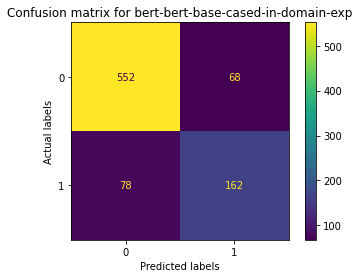




BERT Tokenization Information:
Number of tokens: 171759
Number of tokens that have been split into subwords: 29200
Average number of subwords per token: 1.23
            tokens                  subwords  n_subwords
75          SHOULD      [SH, ##O, ##U, ##LD]           4
83      horrendous  [ho, ##rre, ##ndo, ##us]           4
319     puertorico  [pu, ##ert, ##ori, ##co]           4
382       20180917    [2018, ##0, ##9, ##17]           4
515      ToriesOut   [Tori, ##es, ##O, ##ut]           4
...            ...                       ...         ...
171582     AGAINST     [AG, ##A, ##IN, ##ST]           4
171601      PLAYED      [P, ##LA, ##Y, ##ED]           4
171604      CHOICE      [CH, ##O, ##IC, ##E]           4
171608     ELECTED     [E, ##LE, ##CT, ##ED]           4
171614     ANOTHER     [AN, ##OT, ##H, ##ER]           4

[1287 rows x 3 columns]


In [ ]:
fine_tune_and_eval('in-domain-exp', df_train_olid, df_test, 'bert', 'bert-base-cased')


**Looking at the above output, BERT fails to correctly tokenize:**
* Example 1: horrendous
  * BERT tokenization: [ho, ##rre, ##ndo, ##us]
  * Morphologically expected split: [horrendous]
* Example 2: puertorico
  * BERT tokenization: [pu, ##ert, ##ori, ##co]
  * Morphologically expected split: [puertorico]
* Example 3: PLAYED    
  * BERT tokenization: [P, ##LA, ##Y, ##ED] 
  * Morphologically expected split: [PLAY, ED]
* Example 4: ELECTED
  * BERT tokenization: [E, ##LE, ##CT, ##ED]
  * Morphologically expected split: [ELECT, ED]


#### b.	Cross-domain experiments (hasoc-train.csv)

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]


------------Metrics for bert-bert-base-cased-cross-domain-exp:------------
              precision    recall  f1-score   support

           0     0.8449    0.9048    0.8738       620
           1     0.6990    0.5708    0.6284       240

    accuracy                         0.8116       860
   macro avg     0.7719    0.7378    0.7511       860
weighted avg     0.8042    0.8116    0.8054       860



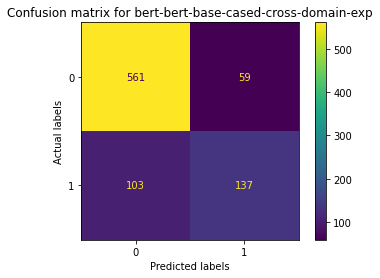




BERT Tokenization Information:
Number of tokens: 188144
Number of tokens that have been split into subwords: 35712
Average number of subwords per token: 1.62
                tokens                      subwords  n_subwords
43            politico        [p, ##oli, ##tic, ##o]           4
113          TeamIndia       [Team, ##I, ##ndi, ##a]           4
169            CWC2019         [CW, ##C, ##20, ##19]           4
177        trendingnow     [trend, ##ing, ##no, ##w]           4
226         FuckRacism      [Fuck, ##R, ##ac, ##ism]           4
...                ...                           ...         ...
187721  Anything4Votes  [Anything, ##4, ##V, ##otes]           4
187969       SirJadeja       [Sir, ##J, ##ade, ##ja]           4
188026       davidfrum       [da, ##vid, ##f, ##rum]           4
188066       magamyass       [ma, ##gam, ##yas, ##s]           4
188111          RUNDIA          [R, ##UN, ##DI, ##A]           4

[5122 rows x 3 columns]


In [ ]:
fine_tune_and_eval('cross-domain-exp', df_train_hasoc, df_test, 'bert', 'bert-base-cased')

**Looking at the above output:**
* Example 1: TeamIndia
  * BERT tokenization: [Team, ##I, ##ndi, ##a]
  * Morphologically expected split: [Team, India]
* Example 2: FuckRacism
  * BERT tokenization: [Fuck, ##R, ##ac, ##ism]
  * Morphologically expected split: [Fuck, Race, ism]
* Example 3: SirJadeja    
  * BERT tokenization: [Sir, ##J, ##ade, ##ja]
  * Morphologically expected split: [Sir, Jadeja]
* Example 4: magamyass
  * BERT tokenization: [ma, ##gam, ##yas, ##s]
  * Morphologically expected split: [maga, my, ass]


## B. Classification by fine-tuning RoBERTa

#### a.	In-domain experiments (olid-train-small.csv)

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]


------------Metrics for roberta-roberta-base-in-domain-exp:------------
              precision    recall  f1-score   support

           0     0.8593    0.9355    0.8958       620
           1     0.7838    0.6042    0.6824       240

    accuracy                         0.8430       860
   macro avg     0.8215    0.7698    0.7891       860
weighted avg     0.8382    0.8430    0.8362       860



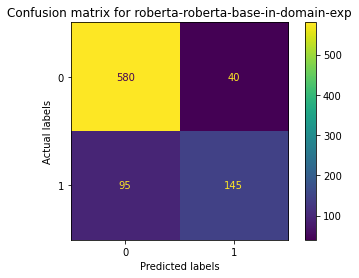

In [ ]:
fine_tune_and_eval('in-domain-exp', df_train_olid, df_test, 'roberta', 'roberta-base')


#### b.	Cross-domain experiments (hasoc-train.csv)

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]


------------Metrics for roberta-roberta-base-cross-domain-exp:------------
              precision    recall  f1-score   support

           0     0.7209    1.0000    0.8378       620
           1     0.0000    0.0000    0.0000       240

    accuracy                         0.7209       860
   macro avg     0.3605    0.5000    0.4189       860
weighted avg     0.5197    0.7209    0.6040       860



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


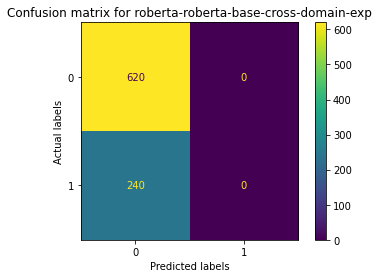

In [ ]:
fine_tune_and_eval('cross-domain-exp', df_train_hasoc, df_test, 'roberta', 'roberta-base')

## C. Classification using XLNet

#### a.	In-domain experiments (olid-train-small.csv)

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]


------------Metrics for xlnet-xlnet-base-cased-in-domain-exp:------------
              precision    recall  f1-score   support

           0     0.8736    0.8919    0.8827       620
           1     0.7048    0.6667    0.6852       240

    accuracy                         0.8291       860
   macro avg     0.7892    0.7793    0.7840       860
weighted avg     0.8265    0.8291    0.8276       860



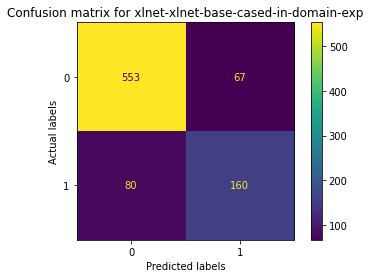

In [ ]:
fine_tune_and_eval('in-domain-exp', df_train_olid, df_test, 'xlnet', 'xlnet-base-cased')


#### b.	Cross-domain experiments (hasoc-train.csv)

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]


------------Metrics for xlnet-xlnet-base-cased-cross-domain-exp:------------
              precision    recall  f1-score   support

           0     0.7811    0.8919    0.8328       620
           1     0.5592    0.3542    0.4337       240

    accuracy                         0.7419       860
   macro avg     0.6701    0.6231    0.6333       860
weighted avg     0.7192    0.7419    0.7214       860



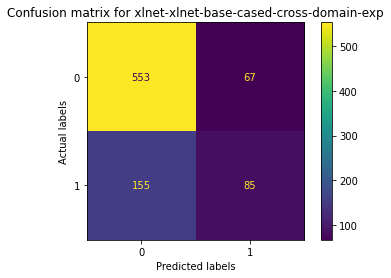

In [ ]:
fine_tune_and_eval('cross-domain-exp', df_train_hasoc, df_test, 'xlnet', 'xlnet-base-cased')

## D. Classification using [HateBERT](https://huggingface.co/GroNLP/hateBERT), [Caselli et al., 2021](https://aclanthology.org/2021.woah-1.3/)

#### a.	In-domain experiments (olid-train-small.csv)

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]


------------Metrics for bert-GroNLP-hateBERT-in-domain-exp:------------
              precision    recall  f1-score   support

           0     0.8657    0.9048    0.8849       620
           1     0.7217    0.6375    0.6770       240

    accuracy                         0.8302       860
   macro avg     0.7937    0.7712    0.7809       860
weighted avg     0.8255    0.8302    0.8268       860



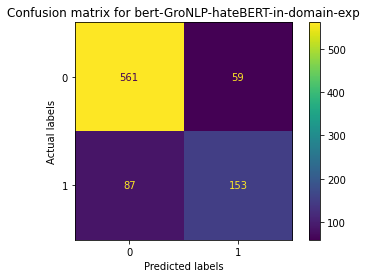




BERT Tokenization Information:
Number of tokens: 171759
Number of tokens that have been split into subwords: 4171
Average number of subwords per token: 1.04
               tokens                     subwords  n_subwords
83         horrendous     [ho, ##rre, ##ndo, ##us]           4
382          20180917       [2018, ##0, ##9, ##17]           4
1966        complicit      [com, ##pl, ##ici, ##t]           4
2112     contemplates   [con, ##tem, ##plate, ##s]           4
2662       brexiteers     [br, ##ex, ##ite, ##ers]           4
...               ...                          ...         ...
169938  corroboration  [co, ##rro, ##bor, ##ation]           4
170251   adminstrator   [ad, ##mins, ##tra, ##tor]           4
170625   insufferable   [ins, ##uf, ##fera, ##ble]           4
171353     horrendous     [ho, ##rre, ##ndo, ##us]           4
171546       oxymoron       [ox, ##ym, ##oro, ##n]           4

[295 rows x 3 columns]


In [ ]:
fine_tune_and_eval('in-domain-exp', df_train_olid, df_test, 'bert', 'GroNLP/hateBERT')


#### b.	Cross-domain experiments (hasoc-train.csv)

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]


------------Metrics for bert-GroNLP-hateBERT-cross-domain-exp:------------
              precision    recall  f1-score   support

           0     0.8537    0.8661    0.8599       620
           1     0.6407    0.6167    0.6285       240

    accuracy                         0.7965       860
   macro avg     0.7472    0.7414    0.7442       860
weighted avg     0.7943    0.7965    0.7953       860



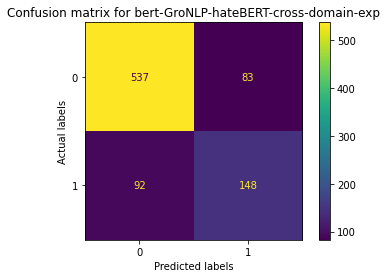




BERT Tokenization Information:
Number of tokens: 188144
Number of tokens that have been split into subwords: 8829
Average number of subwords per token: 1.10
                 tokens                       subwords  n_subwords
343          compulsive       [com, ##pu, ##ls, ##ive]           4
525        iowaspeedway     [iowa, ##sp, ##eed, ##way]           4
529         rileyherbst      [riley, ##her, ##bs, ##t]           4
536         rileyherbst      [riley, ##her, ##bs, ##t]           4
567        dealoftheday     [deal, ##oft, ##hed, ##ay]           4
...                 ...                            ...         ...
187261       disbarment       [di, ##sb, ##arm, ##ent]           4
187300  briantylercohen  [brian, ##tyle, ##rco, ##hen]           4
187396      hyphenating      [h, ##yp, ##hen, ##ating]           4
187481       mpvadodara       [mp, ##va, ##do, ##dara]           4
187986   englandcricket   [england, ##cr, ##ick, ##et]           4

[1219 rows x 3 columns]


In [ ]:
fine_tune_and_eval('cross-domain-exp', df_train_hasoc, df_test, 'bert', 'GroNLP/hateBERT')

## E. Classification using [fBERT](https://huggingface.co/diptanu/fBERT), [Sarkar et al., 2021](https://aclanthology.org/2021.findings-emnlp.154/)

#### a.	In-domain experiments (olid-train-small.csv)

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]


------------Metrics for bert-diptanu-fBERT-in-domain-exp:------------
              precision    recall  f1-score   support

           0     0.8669    0.9032    0.8847       620
           1     0.7196    0.6417    0.6784       240

    accuracy                         0.8302       860
   macro avg     0.7932    0.7724    0.7815       860
weighted avg     0.8258    0.8302    0.8271       860



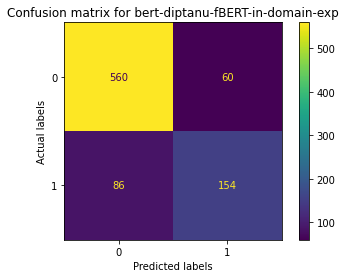




BERT Tokenization Information:
Number of tokens: 171759
Number of tokens that have been split into subwords: 4171
Average number of subwords per token: 1.04
               tokens                     subwords  n_subwords
83         horrendous     [ho, ##rre, ##ndo, ##us]           4
382          20180917       [2018, ##0, ##9, ##17]           4
1966        complicit      [com, ##pl, ##ici, ##t]           4
2112     contemplates   [con, ##tem, ##plate, ##s]           4
2662       brexiteers     [br, ##ex, ##ite, ##ers]           4
...               ...                          ...         ...
169938  corroboration  [co, ##rro, ##bor, ##ation]           4
170251   adminstrator   [ad, ##mins, ##tra, ##tor]           4
170625   insufferable   [ins, ##uf, ##fera, ##ble]           4
171353     horrendous     [ho, ##rre, ##ndo, ##us]           4
171546       oxymoron       [ox, ##ym, ##oro, ##n]           4

[295 rows x 3 columns]


In [ ]:
fine_tune_and_eval('in-domain-exp', df_train_olid, df_test, 'bert', 'diptanu/fBERT')


#### b.	Cross-domain experiments (hasoc-train.csv)

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]


------------Metrics for bert-diptanu-fBERT-cross-domain-exp:------------
              precision    recall  f1-score   support

           0     0.8391    0.9419    0.8875       620
           1     0.7805    0.5333    0.6337       240

    accuracy                         0.8279       860
   macro avg     0.8098    0.7376    0.7606       860
weighted avg     0.8227    0.8279    0.8167       860



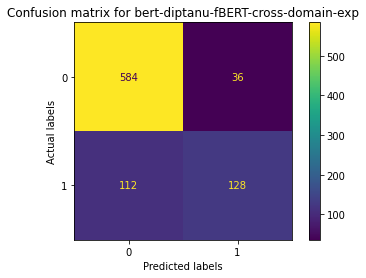




BERT Tokenization Information:
Number of tokens: 188144
Number of tokens that have been split into subwords: 8829
Average number of subwords per token: 1.10
                 tokens                       subwords  n_subwords
343          compulsive       [com, ##pu, ##ls, ##ive]           4
525        iowaspeedway     [iowa, ##sp, ##eed, ##way]           4
529         rileyherbst      [riley, ##her, ##bs, ##t]           4
536         rileyherbst      [riley, ##her, ##bs, ##t]           4
567        dealoftheday     [deal, ##oft, ##hed, ##ay]           4
...                 ...                            ...         ...
187261       disbarment       [di, ##sb, ##arm, ##ent]           4
187300  briantylercohen  [brian, ##tyle, ##rco, ##hen]           4
187396      hyphenating      [h, ##yp, ##hen, ##ating]           4
187481       mpvadodara       [mp, ##va, ##do, ##dara]           4
187986   englandcricket   [england, ##cr, ##ick, ##et]           4

[1219 rows x 3 columns]


In [ ]:
fine_tune_and_eval('cross-domain-exp', df_train_hasoc, df_test, 'bert', 'diptanu/fBERT')

# Other Models

## A. NB

#### a.	In-domain experiments (olid-train-small.csv)

              precision    recall  f1-score   support

           0       0.76      0.99      0.86       620
           1       0.92      0.19      0.31       240

    accuracy                           0.77       860
   macro avg       0.84      0.59      0.59       860
weighted avg       0.80      0.77      0.71       860


[[616   4]
 [195  45]]
0.7686046511627908


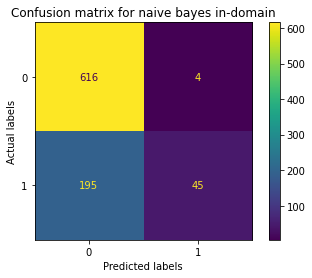

In [ ]:
### Naive Bayes ###
### OLID ###
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Build the model
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
# Train the model using the training data
model.fit(df_train_olid.text, df_train_olid.labels)
# Predict the categories of the test data
predicted_categories = model.predict(df_test.text)

mat = accuracy_score(df_test.labels, predicted_categories)

print(classification_report(df_test.labels, predicted_categories))
print()
print(confusion_matrix(df_test.labels, predicted_categories))
print(mat)
print_cm(df_test.labels, predicted_categories, dataset_name = 'naive bayes in-domain')

#### b.	Cross-domain experiments (hasoc-train.csv)

              precision    recall  f1-score   support

           0       0.75      0.98      0.85       620
           1       0.77      0.15      0.25       240

    accuracy                           0.75       860
   macro avg       0.76      0.57      0.55       860
weighted avg       0.75      0.75      0.68       860


[[609  11]
 [204  36]]
0.75


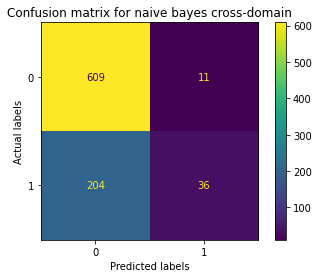

In [ ]:
### Hasoc ###
# Build the model
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
# Train the model using the training data
model.fit(df_train_hasoc.text, df_train_hasoc.labels)
# Predict the categories of the test data
predicted_categories = model.predict(df_test.text)

mat = accuracy_score(df_test.labels, predicted_categories)

print(classification_report(df_test.labels, predicted_categories))
print(confusion_matrix(df_test.labels, predicted_categories))
print(mat)
print_cm(df_test.labels, predicted_categories, dataset_name = 'naive bayes cross-domain')

## B. Linear SVM 

#### a.	In-domain experiments (olid-train-small.csv)

SVM Accuracy Score ->  79.88372093023256
F1 Accuracy Score ->  56.64160401002506
Precision Accuracy Score ->  47.083333333333336
Recall Accuracy Score ->  71.0691823899371
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       620
           1       0.71      0.47      0.57       240

    accuracy                           0.80       860
   macro avg       0.76      0.70      0.72       860
weighted avg       0.79      0.80      0.78       860


[[574  46]
 [127 113]]
0.7988372093023256


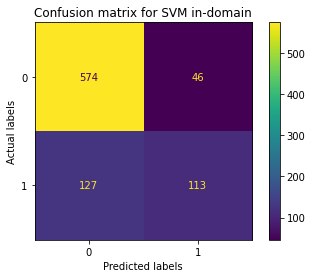

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df_train_olid.text)

Train_X_Tfidf = Tfidf_vect.transform(df_train_olid.text)
Test_X_Tfidf = Tfidf_vect.transform(df_test.text)

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf, df_train_olid.labels)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, df_test.labels)*100)
print("F1 Accuracy Score -> ",f1_score(predictions_SVM, df_test.labels)*100)
print("Precision Accuracy Score -> ",precision_score(predictions_SVM, df_test.labels)*100)
print("Recall Accuracy Score -> ",recall_score(predictions_SVM, df_test.labels)*100)

mat = accuracy_score(df_test.labels, predictions_SVM)

print(classification_report(df_test.labels, predictions_SVM))
print()
print(confusion_matrix(df_test.labels, predictions_SVM))
print(mat)
print_cm(df_test.labels, predictions_SVM, dataset_name = 'SVM in-domain')


#### b.	Cross-domain experiments (hasoc-train.csv)

SVM Accuracy Score ->  64.18604651162791
F1 Accuracy Score ->  43.17343173431734
Precision Accuracy Score ->  48.75
Recall Accuracy Score ->  38.741721854304636
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       620
           1       0.39      0.49      0.43       240

    accuracy                           0.64       860
   macro avg       0.58      0.59      0.59       860
weighted avg       0.67      0.64      0.65       860


[[435 185]
 [123 117]]
0.641860465116279


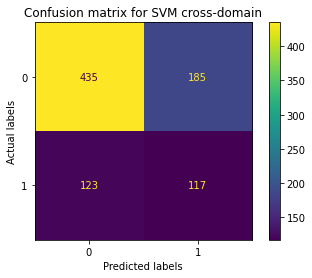

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df_train_hasoc.text)

Train_X_Tfidf = Tfidf_vect.transform(df_train_hasoc.text)
Test_X_Tfidf = Tfidf_vect.transform(df_test.text)

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf, df_train_hasoc.labels)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, df_test.labels)*100)
print("F1 Accuracy Score -> ",f1_score(predictions_SVM, df_test.labels)*100)
print("Precision Accuracy Score -> ",precision_score(predictions_SVM, df_test.labels)*100)
print("Recall Accuracy Score -> ",recall_score(predictions_SVM, df_test.labels)*100)

mat = accuracy_score(df_test.labels, predictions_SVM)

print(classification_report(df_test.labels, predictions_SVM))
print()
print(confusion_matrix(df_test.labels, predictions_SVM))
print(mat)
print_cm(df_test.labels, predictions_SVM, dataset_name = 'SVM cross-domain')


## C. CNN

#### a.	In-domain experiments (olid-train-small.csv)


In [ ]:
# Tokenize the data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_train_olid.text)

# Create train and test datasets on tokenized data
X_train = tokenizer.texts_to_sequences(df_train_olid.text)
X_test = tokenizer.texts_to_sequences(df_test.text)

maxlen = 100
embedding_dim = 50

# create and fit paddings accordingly in order to use the cnn
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1

# Initialize the model accordingly
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           663950    
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 10)                50010     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 713,971
Trainable params: 713,971
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model using the train set and the labels
history = model.fit(X_train, df_train_olid.labels,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, df_test.labels),
                    batch_size=10)

# evaluate the model and print basic results
loss, accuracy = model.evaluate(X_train, df_train_olid.labels, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, df_test.labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))



Epoch 1/20
586/586 [==============================] - 3s 4ms/step - loss: 0.6662 - accuracy: 0.6109 - val_loss: 0.6121 - val_accuracy: 0.7209
Epoch 2/20
586/586 [==============================] - 2s 4ms/step - loss: 0.5335 - accuracy: 0.7377 - val_loss: 0.5090 - val_accuracy: 0.7640
Epoch 3/20
586/586 [==============================] - 2s 4ms/step - loss: 0.2727 - accuracy: 0.8976 - val_loss: 0.6268 - val_accuracy: 0.7198
Epoch 4/20
586/586 [==============================] - 2s 4ms/step - loss: 0.1111 - accuracy: 0.9668 - val_loss: 0.6758 - val_accuracy: 0.7372
Epoch 5/20
586/586 [==============================] - 2s 4ms/step - loss: 0.0483 - accuracy: 0.9877 - val_loss: 0.7665 - val_accuracy: 0.7453
Epoch 6/20
586/586 [==============================] - 2s 4ms/step - loss: 0.0293 - accuracy: 0.9933 - val_loss: 0.8735 - val_accuracy: 0.7453
Epoch 7/20
586/586 [==============================] - 2s 4ms/step - loss: 0.0212 - accuracy: 0.9944 - val_loss: 1.0823 - val_accuracy: 0.6767
Epoch 

27/27 [==============================] - 0s 1ms/step


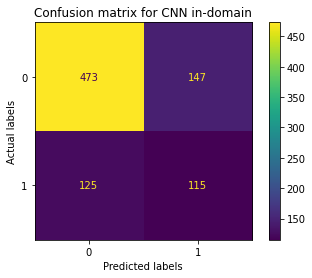

              precision    recall  f1-score   support

           0       0.79      0.76      0.78       620
           1       0.44      0.48      0.46       240

    accuracy                           0.68       860
   macro avg       0.61      0.62      0.62       860
weighted avg       0.69      0.68      0.69       860



In [ ]:
# predict on the test set and transform output into binary
predictions = model.predict(X_test)
labels = np.array(df_test.labels)
rounded = np.where(predictions > 0.5, 1, 0)

# create and print confusion matrices and classification report
conf_matrix = tf.math.confusion_matrix(labels=labels,predictions=rounded)
conf_matrix_2 = tf.math.confusion_matrix(labels=labels,predictions=predictions)
print_cm(labels, rounded, dataset_name = 'CNN in-domain')
print(classification_report(df_test.labels, rounded))

#### b.	Cross-domain experiments (hasoc-train.csv)

In [ ]:
# Tokenize the data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_train_hasoc.text)

# Create train and test datasets on tokenized data
X_train = tokenizer.texts_to_sequences(df_train_hasoc.text)
X_test = tokenizer.texts_to_sequences(df_test.text)

maxlen = 100
embedding_dim = 50

# create and fit paddings accordingly in order to use the cnn
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1

# Initialize the model accordingly
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# fit the model using the train set and the labels
history = model.fit(X_train, df_train_hasoc.labels,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, df_test.labels),
                    batch_size=10)

# evaluate the model and print basic results
loss, accuracy = model.evaluate(X_train, df_train_hasoc.labels, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, df_test.labels, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))



Epoch 1/20
586/586 [==============================] - 3s 4ms/step - loss: 0.6498 - accuracy: 0.6181 - val_loss: 0.6139 - val_accuracy: 0.6767
Epoch 2/20
586/586 [==============================] - 2s 4ms/step - loss: 0.4368 - accuracy: 0.8047 - val_loss: 0.6469 - val_accuracy: 0.6640
Epoch 3/20
586/586 [==============================] - 2s 4ms/step - loss: 0.1523 - accuracy: 0.9568 - val_loss: 0.7790 - val_accuracy: 0.6442
Epoch 4/20
586/586 [==============================] - 2s 4ms/step - loss: 0.0849 - accuracy: 0.9757 - val_loss: 0.9105 - val_accuracy: 0.6314
Epoch 5/20
586/586 [==============================] - 2s 4ms/step - loss: 0.0607 - accuracy: 0.9843 - val_loss: 0.9548 - val_accuracy: 0.6465
Epoch 6/20
586/586 [==============================] - 2s 4ms/step - loss: 0.0475 - accuracy: 0.9841 - val_loss: 1.0548 - val_accuracy: 0.6512
Epoch 7/20
586/586 [==============================] - 2s 4ms/step - loss: 0.0409 - accuracy: 0.9853 - val_loss: 1.0208 - val_accuracy: 0.6407
Epoch 

27/27 [==============================] - 0s 1ms/step


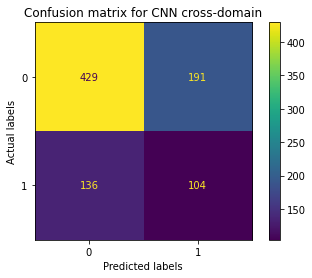

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       620
           1       0.35      0.43      0.39       240

    accuracy                           0.62       860
   macro avg       0.56      0.56      0.56       860
weighted avg       0.65      0.62      0.63       860



In [ ]:
# predict on the test set and transform output into binary

predictions = model.predict(X_test)
labels = np.array(df_test.labels)
rounded = np.where(predictions > 0.5, 1, 0)

# print confusion matrices and classification report
conf_matrix = tf.math.confusion_matrix(labels=labels,predictions=rounded)
print_cm(labels, rounded, dataset_name = 'CNN cross-domain')
print(classification_report(df_test.labels, rounded))